In [1]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import sys, pathlib
repo_root = pathlib.Path('./st-celltype-deconvolution/src/models').resolve()
sys.path.insert(0, str(repo_root))

from vae_sc import VAE, vae_loss, compute_uncertainty
from uncertainty_gcn import UncertaintyGCN, compute_loss
from gcn_claude import ImprovedUncertaintyGCN, improved_loss

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# ================== 1. 读取数据 ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")
# 统一基因集并一致归一化（scRNA 与 ST 必须使用同一 gene set 和相同变换）
genes = scRNA.var_names.intersection(ST.var_names)
scRNA = scRNA[:, genes].copy()
ST = ST[:, genes].copy()

# 统一归一化策略（两端都用 total-count normalization + log1p）
def _is_log_transformed(adata):
    X = adata.X
    if hasattr(X, "A"): X = X.A
    arr = np.asarray(X)
    if arr.size == 0:
        return False
    if np.nanmax(arr) > 100:
        return False
    return True

for name, ad in (("scRNA", scRNA), ("ST", ST)):
    # 先检查当前 ad.X（不要先覆盖它）
    X_curr = ad.X.A if hasattr(ad.X, "A") else ad.X
    print(f"{name}: current ad.X max={np.nanmax(X_curr):.4f}")
    if _is_log_transformed(ad):
        print(f"{name}: appears already log-transformed, skipping normalize/log1p (max={np.nanmax(X_curr):.4f})")
        # 保留原有 ad.X，不做覆盖
    else:
        # 只有在 ad.X 看起来是 raw counts 时才取 counts layer 或 ad.X 做归一+log1p
        mat = ad.layers["counts"] if "counts" in ad.layers else ad.X
        mat = mat.A if hasattr(mat, "A") else mat
        ad.layers["norm_counts"] = mat  # 保留原始稀疏/原始 counts
        ad.X = ad.layers["norm_counts"]  # 现在 ad.X 是 raw counts，下面做 normalize+log1p
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        print(f"{name}: applied normalize_total + log1p (new max={np.nanmax(ad.X):.4f})")

# 现在再取 X_sc, X_st 并转成 numpy / torch
if "counts" in scRNA.layers:
    X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
else:
    X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X

if "counts" in ST.layers:
    X_st = ST.X.A if hasattr(ST.X, "A") else ST.X
else:
    X_st = ST.X.A if hasattr(ST.X, "A") else ST.X

# 最后转 torch 并送到 device
X_sc = torch.tensor(np.asarray(X_sc), dtype=torch.float32).to(device)
X_st = torch.tensor(np.asarray(X_st), dtype=torch.float32).to(device)
labels = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)
# debug 打印，强制断言维度一致
print("genes count:", len(genes))
print("X_sc.shape:", X_sc.shape, "X_st.shape:", X_st.shape)
# ...existing code...

celltypes = scRNA.obs["broad_cell_types"].astype("category").cat.categories.tolist()

使用设备: cuda
scRNA: current ad.X max=11.3014
scRNA: appears already log-transformed, skipping normalize/log1p (max=11.3014)
ST: current ad.X max=7.7890
ST: appears already log-transformed, skipping normalize/log1p (max=7.7890)
genes count: 1888
X_sc.shape: torch.Size([14989, 1888]) X_st.shape: torch.Size([1092, 1888])


In [3]:
def train_vae_with_scheduling(vae, dataloader, num_epochs=100, device="cpu"):
    """带学习率调度和早停的VAE训练"""
    vae = vae.to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )
    
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    # 逐步增加KL权重
    beta_start, beta_end = 0.0001, 0.01
    beta_schedule = np.linspace(beta_start, beta_end, num_epochs//2)
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_loss = 0
        
        # 设置当前beta值
        beta = beta_end if epoch >= len(beta_schedule) else beta_schedule[epoch]
        
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            
            dec_mu, dec_theta, dec_pi, mu, logvar = vae(x_batch)
            loss, zinb, kl = vae_loss(x_batch, dec_mu, dec_theta, dec_pi, mu, logvar, beta=beta)
            
            loss.backward()
            # 梯度裁剪防止爆炸
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Beta: {beta:.6f}")
        
        # 验证并调整学习率
        scheduler.step(avg_loss)
        
        # 早停
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(vae.state_dict(), "best_vae_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    # 加载最佳模型
    vae.load_state_dict(torch.load("best_vae_model.pt"))
    return vae

Epoch 1/100, Loss: 0.5666, Beta: 0.000100
Epoch 11/100, Loss: 0.4811, Beta: 0.002120
Epoch 21/100, Loss: 0.4777, Beta: 0.004141
Epoch 31/100, Loss: 0.4776, Beta: 0.006161
Epoch 41/100, Loss: 0.4751, Beta: 0.008182
Epoch 51/100, Loss: 0.4736, Beta: 0.010000
Epoch 61/100, Loss: 0.4722, Beta: 0.010000
Epoch 71/100, Loss: 0.4717, Beta: 0.010000
Epoch 81/100, Loss: 0.4722, Beta: 0.010000
Epoch 91/100, Loss: 0.4706, Beta: 0.010000
细胞类型不确定性: [0.777046   0.7495264  0.54673696 0.46171784 1.         0.20014212
 0.01267169 0.48054284 0.63505065 0.607046   0.         0.16635932]


/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634756/1576664576.py:57: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from curren

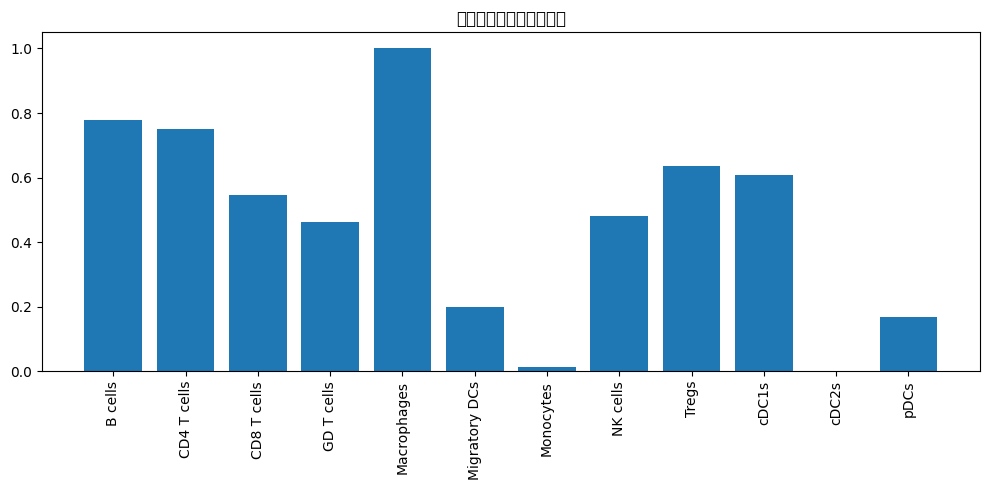

In [4]:

dataset = TensorDataset(X_sc, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
n_genes = X_sc.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 训练VAE（使用优化的训练函数）
vae = train_vae_with_scheduling(
    vae=vae,
    dataloader=dataloader,
    num_epochs=100,  # 可根据需要调整
    device=device
)

# 也可以用更简单的训练循环
"""
epochs = 50
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(1, epochs+1):
    vae.train()
    sum_loss = sum_recon = sum_kl = 0.0
    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x_batch)
        loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar, beta=1e-3)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        sum_recon += recon.item()
        sum_kl += kl.item()

    if epoch % 10 == 0:
        print(f"VAE Epoch {epoch}/{epochs}, loss={sum_loss:.2f}, recon={sum_recon:.2f}, kl={sum_kl:.2f}")
"""

# 计算细胞类型不确定性
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)

# 归一化细胞类型不确定性作为GCN的输入
type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
print("细胞类型不确定性:", type_unc)

# 可视化不确定性
plt.figure(figsize=(10, 5))
plt.bar(range(len(type_unc)), type_unc)
plt.xticks(range(len(type_unc)), celltypes, rotation=90)
plt.title("每种细胞类型的不确定性")
plt.tight_layout()
plt.show()

直接加载模型版

/tmp/ipykernel_2634118/2921629873.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_st = torch.tensor(X_st, dtype=torch.float32).to(device)


细胞类型不确定性: [3.4653568e-03 2.1611869e-02 1.0000000e+00 8.5666187e-02 7.3003292e-02
 7.7121193e-04 4.0012738e-01 1.8563420e-02 0.0000000e+00 8.1469691e-01
 9.9499352e-02 3.4150310e-02]


/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2634118/2921629873.py:49: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from curren

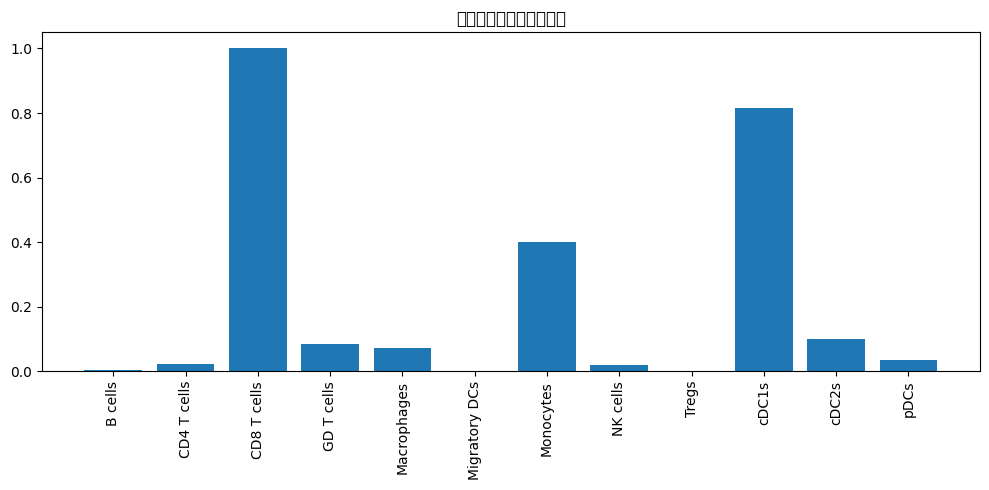

In [16]:
# 准备数据
if "counts" in scRNA.layers:
    X_sc = scRNA.layers["counts"]
else:
    X_sc = scRNA.X

# 稀疏转稠密
if hasattr(X_sc, "toarray"):
    X_sc = X_sc.toarray()
elif hasattr(X_sc, "A"):  # 某些稀疏类型
    X_sc = X_sc.A

X_st = torch.tensor(X_st, dtype=torch.float32).to(device)
# X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
X_sc = torch.tensor(X_sc, dtype=torch.float32)
labels = scRNA.obs["cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(X_sc, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
n_genes = X_sc.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 1. 加载VAE最佳模型参数
vae.load_state_dict(torch.load("best_vae_model.pt", map_location=device))
vae.eval()

# 2. 计算细胞类型不确定性（推断即可）
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)

# 3. 归一化细胞类型不确定性作为GCN的输入
type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
print("细胞类型不确定性:", type_unc)

# 4. 可视化
plt.figure(figsize=(10, 5))
plt.bar(range(len(type_unc)), type_unc)
plt.xticks(range(len(type_unc)), celltypes, rotation=90)
plt.title("每种细胞类型的不确定性")
plt.tight_layout()
plt.show()

vae训练完毕，得到细胞类型水平的不确定性

In [5]:
def get_reference_profile(sc_adata, celltype_key="broad_cell_types", use_layer=None):
    """
    返回 shape: [n_types, n_genes] 的参考表达谱，确保使用与 ST 相同的归一化（传入的 sc_adata 应已归一化并 log1p）。
    """
    celltypes = sc_adata.obs[celltype_key].astype("category").cat.categories
    expr = []
    for ct in celltypes:
        mask = (sc_adata.obs[celltype_key] == ct)
        X = sc_adata[mask].X
        X = X.A if hasattr(X, "A") else X
        expr.append(np.asarray(X).mean(axis=0))
    expr = np.stack(expr, axis=0)  # shape: [n_types, n_genes]
    return expr, list(celltypes), list(sc_adata.var_names)
E, ref_celltypes, ref_genes = get_reference_profile(scRNA, celltype_key="broad_cell_types")
print("E.shape:", E.shape)
assert E.shape[1] == X_st.shape[1], "参考表达谱 E 的基因数量与 ST 输入 X_st 不匹配！"

E.shape: (12, 1888)


In [6]:
# 2. 构建空间邻接关系（edge_index），假设ST_train有空间坐标
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
edges = nbrs.kneighbors_graph(coords).tocoo()
edge_index = np.vstack([edges.row, edges.col])
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

# 3. 初始化GCN模型
n_types = len(celltypes)
gcn = ImprovedUncertaintyGCN(
    in_dim=X_st.shape[1],
    hidden_dim=128,
    n_types=n_types,
    type_uncertainty=type_unc,
    dropout=0.2
).to(device)

# 4. 训练GCN
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 500
# E = ... # 你的参考表达谱（shape: n_types, n_genes），需提前准备好

best_loss = float('inf')
patience = 30
patience_counter = 0

for epoch in range(epochs):
    gcn.train()
    optimizer.zero_grad()
    pred = gcn(X_st, edge_index)  # pred: [n_spots, n_types]
    loss = improved_loss(pred[0], X_st, E, edge_index, type_unc)
    if isinstance(loss, tuple):
        loss = loss[0]
    loss.backward()
    # 检查梯度是否为 0（debug）
    total_grad = 0.0
    for name, param in gcn.named_parameters():
        if param.grad is not None:
            total_grad += param.grad.abs().sum().item()
    # print(f"Epoch {epoch+1}, loss={loss.item():.4f}, total_grad={total_grad:.6f}")
    optimizer.step()

    # 保存最佳模型
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(gcn.state_dict(), "best_gcn_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0:
        print(f"GCN Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}, best_loss={best_loss:.4f}, total_grad={total_grad:.6f}")

# 训练结束后加载最佳模型
gcn.load_state_dict(torch.load("best_gcn_model.pt"))

GCN Epoch 10/500, loss=1.2802, best_loss=1.2802, total_grad=13.442239
GCN Epoch 20/500, loss=1.2651, best_loss=1.2651, total_grad=6.553775
GCN Epoch 30/500, loss=1.2605, best_loss=1.2605, total_grad=5.168646
GCN Epoch 40/500, loss=1.2583, best_loss=1.2582, total_grad=3.413476
GCN Epoch 50/500, loss=1.2567, best_loss=1.2567, total_grad=4.766717
GCN Epoch 60/500, loss=1.2561, best_loss=1.2561, total_grad=4.051881
GCN Epoch 70/500, loss=1.2553, best_loss=1.2553, total_grad=5.341116
GCN Epoch 80/500, loss=1.2552, best_loss=1.2548, total_grad=4.307355
GCN Epoch 90/500, loss=1.2546, best_loss=1.2544, total_grad=6.838969
GCN Epoch 100/500, loss=1.2543, best_loss=1.2541, total_grad=3.251591
GCN Epoch 110/500, loss=1.2540, best_loss=1.2539, total_grad=4.236894
GCN Epoch 120/500, loss=1.2533, best_loss=1.2533, total_grad=3.070859
GCN Epoch 130/500, loss=1.2536, best_loss=1.2532, total_grad=10.128133
GCN Epoch 140/500, loss=1.2531, best_loss=1.2531, total_grad=4.664532
GCN Epoch 150/500, loss=1.2

<All keys matched successfully>

直接加载GCN模型版

In [7]:
# 2. 构建空间邻接关系（edge_index），假设ST_train有空间坐标
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
edges = nbrs.kneighbors_graph(coords).tocoo()
edge_index = np.vstack([edges.row, edges.col])
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

# 3. 初始化GCN模型
n_types = len(celltypes)
gcn = ImprovedUncertaintyGCN(
    in_dim=X_st.shape[1],
    hidden_dim=128,
    n_types=n_types,
    type_uncertainty=type_unc,
    dropout=0.2
).to(device)


# 1. GCN推断，得到每个spot的细胞类型分数
gcn.load_state_dict(torch.load("best_gcn_model.pt"))
gcn.eval()
with torch.no_grad():
    pred = gcn(X_st, edge_index)  # [n_spots, n_types]
    pred = pred[0]

# 2. 用参考表达谱重建spot表达
E_tensor = torch.tensor(E, dtype=torch.float32, device=pred.device)  # [n_types, n_genes]
X_recon = pred @ E_tensor  # [n_spots, n_genes]

# 3. 计算R²
from sklearn.metrics import r2_score
X_true = X_st.cpu().numpy()
X_pred = X_recon.cpu().numpy()
r2 = r2_score(X_true.reshape(-1), X_pred.reshape(-1))
print(f"GCN重建表达的R²: {r2:.4f}")

GCN重建表达的R²: 0.3834


In [ ]:
pred[0].sum()

1.0

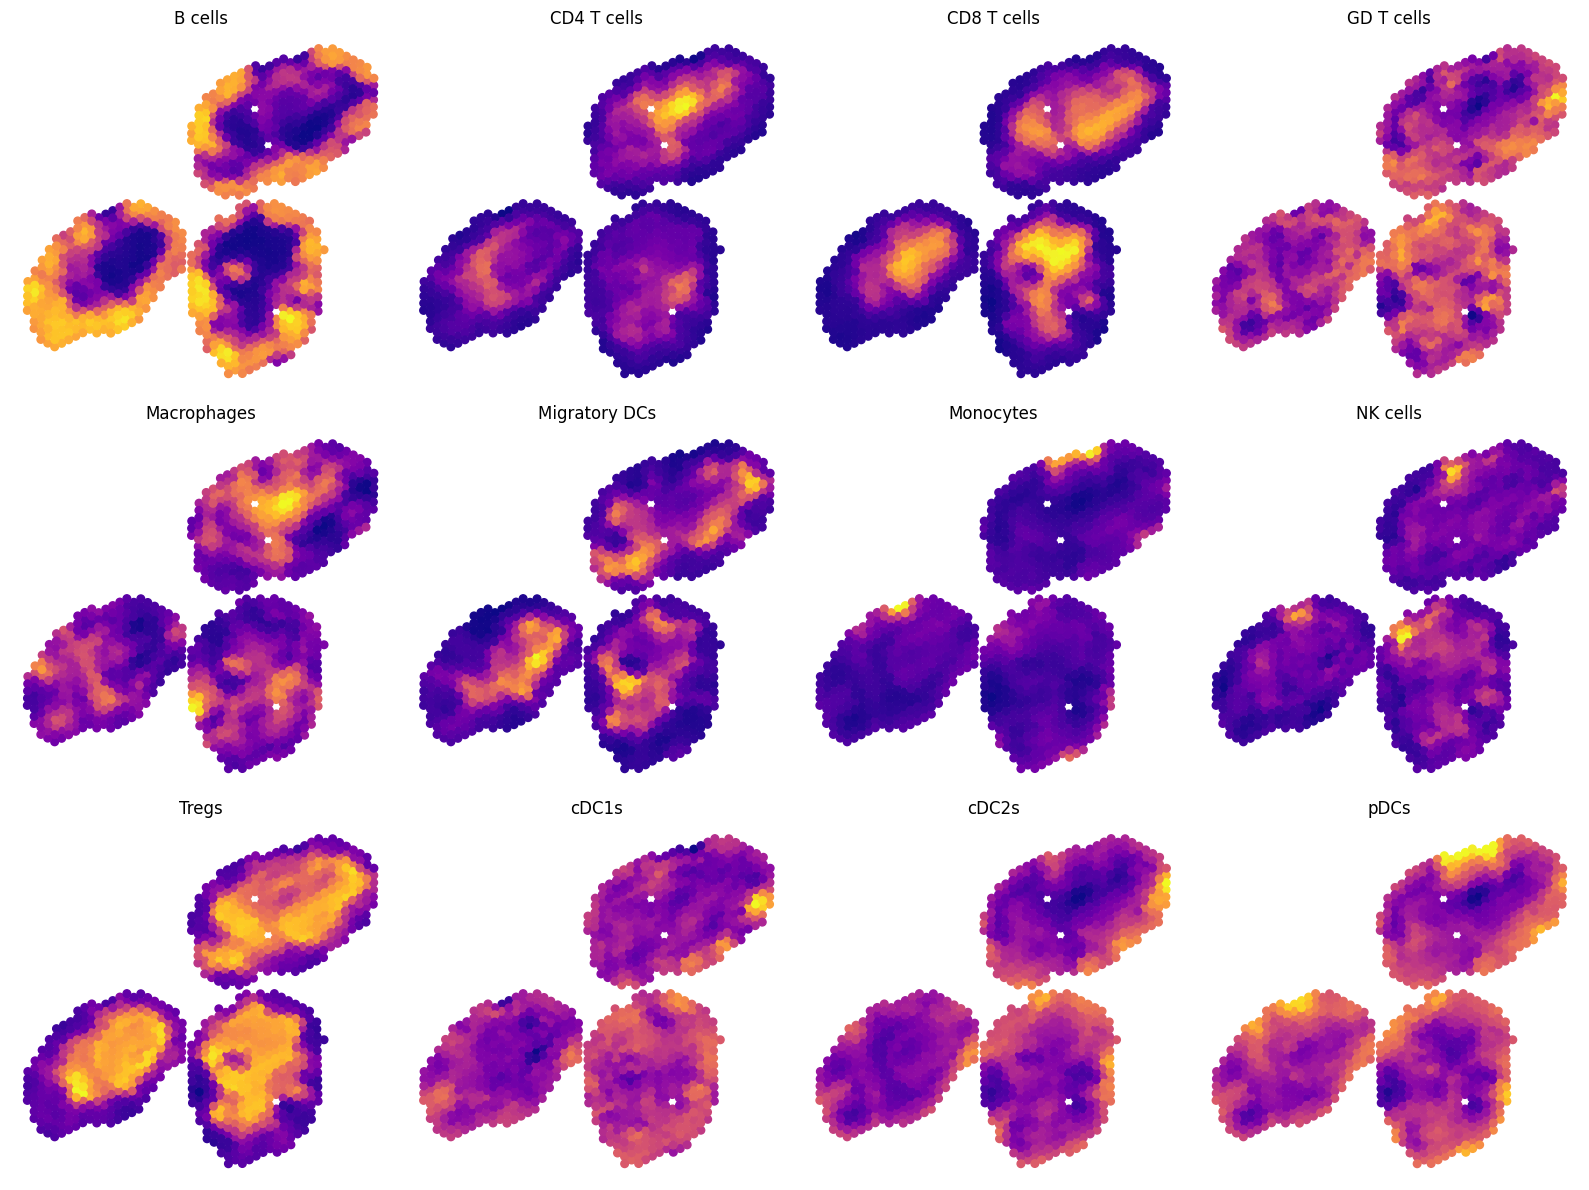

In [9]:
import math

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)
pred = pred.cpu().numpy()  # 加在 for 循环前
plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    # 交换coords的顺序，并翻转y轴
    plt.scatter(coords[:, 1], coords[:, 0], c=pred[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: Us

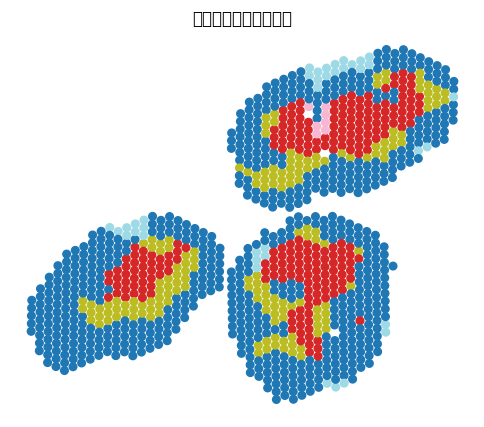

In [12]:
main_type = np.argmax(pred, axis=1)
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 1], coords[:, 0], c=main_type, s=30, cmap='tab20')
plt.title("主导细胞类型空间分布")
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

In [13]:
# pred: [n_spots, n_types]，celltypes: 细胞类型名list
for i, ct in enumerate(celltypes):
    ST.obs[ct] = pred[:, i]

In [14]:
celltypes

['B cells',
 'CD4 T cells',
 'CD8 T cells',
 'GD T cells',
 'Macrophages',
 'Migratory DCs',
 'Monocytes',
 'NK cells',
 'Tregs',
 'cDC1s',
 'cDC2s',
 'pDCs']

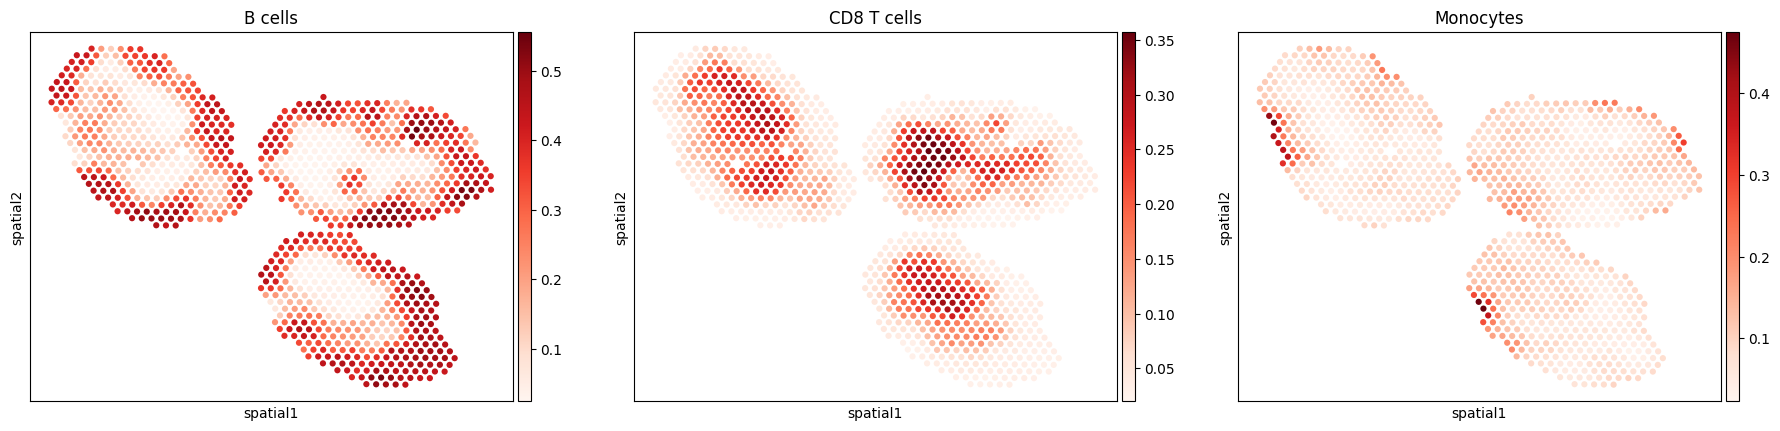

In [15]:
import scanpy as sc
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
# 如果空间坐标在 obsm["spatial"] 或 obsm["location"]，scanpy 会自动识别
sc.pl.embedding(
    ST,
    basis="spatial",  # 或 "location"，看你的 AnnData 里是哪一个
    color=ct_list,  # 画前3个细胞类型
    cmap="Reds",
    s=80
)